# Analyse Rotation Spectra - ALL

## Load Libraries

In [19]:
from andbro__querrySeismoData import __querrySeismoData
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm_notebook
from pathlib import Path
from scipy.stats import median_absolute_deviation as mad

import pickle
import matplotlib.pyplot as plt

In [20]:
!ls "/import/kilauea-data/ROMY/RotationSpectra/data"

overview	      run_2022_ROMY-Z_3600   run_N2_RLAS-Z_3600
run_2019_RLAS-Z_3600  run_N1_RLAS	     run_N2_ROMY
run_2019_ROMY-E_3600  run_N1_ROMY	     run_N2_ROMY-Z_7200
run_2019_ROMY-Z_3600  run_N2019_RLAS-Z_3600  run_N3_RLAS-Z_3600
run_2021_RPFO-E_3600  run_N2019_ROMY-Z_3600  run_N3_ROMY-Z_3600
run_2021_RPFO-N_3600  run_N2_RLAS_7200
run_2021_RPFO-Z_3600  run_N2_RLAS-Z_1800


## Configurations

In [21]:
inname = "run_N2019_RLAS-Z_3600"
# inname = "run_N2019_ROMY-Z_3600"

inpath = f"/import/kilauea-data/ROMY/RotationSpectra/data/{inname}/"

config = pickle.load(open(inpath+inname+"_config.pick", 'rb'))

config['save'] = True

config['inname'] = inname
config['inpath'] = inpath

config['frequency_limits'] = [0.0001, 30]

## Looping 

In [22]:
# def __get_data(config):
#     '''
#     load data and remove response

#     VARIABLES:
#     '''

#     try:
#         st0, inv = __querrySeismoData(    
#                             seed_id=config.get('seed'),
#                             starttime=config.get('tbeg'),
#                             endtime=config.get('tend'),
#                             repository=config['repository'],
#                             path=None,
#                             restitute=False,
#                             detail=None,
#                             )

#     except:
#         print(f"failed to load")
# #         print(f"failed to load {config.get['seed']} {config.get['tbeg']}")
#         return None
    
#     try:
#         st0.remove_response(inventory=inv,output="VEL", zero_mean=True); 
#     except:
#         print(f"failed to remove response")
# #         print(f"failed to remove response {config.get['seed']} {config.get['tbeg']}")
#         return None
    
#     return st0

In [23]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [24]:
def __get_minimum_psd(psds, f_tmp):
    
    from numpy import median
    
    f_before = f_tmp[0]
    f_tmp[0] = 1e-9
    
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_value = (psds[0]/f_tmp).sum()
#             lowest_value = median(psds[0]/f_tmp)
            idx = 0

        value = (psd/f_tmp).sum() 
#         value = median(psd/f_tmp)
        
        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    f_tmp[0] = f_before      
    
    return psds[idx]

In [25]:
def __save_config(config):
    
    ofile = open(config['outpath']+config['outname']+"_config.pick", 'wb')
    pickle.dump(config, ofile)

    if Path(config['outpath']+config['outname']+"_config.pick").exists():
        print(f"created: {config['outpath']}{config['outname']}_config.pick")

In [26]:
def __write_to_csv(data, text, config):
    
    import csv
    
    opath = config['outpath']
    oname = config['outname']+"_"+text+"_psd.csv"
    
    # open the file in the write mode
    with open(opath+oname, 'w') as file:

        writer = csv.writer(file)
        for row in data:
            writer.writerow(row)
            
    if Path(opath+oname).exists():
        print(f"created: {opath}{oname}")

In [27]:
# def __calculate_spectra(st, config, mode='dB'):

#     from datetime import datetime
#     from pandas import date_range
#     from obspy import UTCDateTime
#     from scipy.signal import welch
#     from numpy import where, array, zeros
    
#     def __check_stream(st):
#         t1 = str(st[0].stats.starttime)
#         t2 = str(st[0].stats.endtime)
#         for tr in st:
#             if str(tr.stats.starttime) != t1 or str(tr.stats.endtime) != t2:
#                 print(f"ERROR: mismatch in start or endtime of trace: {tr.stats.id}")
#                 return
            
#     def __make_decibel(array, relative_value):
#         return 10*log10(array/relative_value) 
    
#     ## check time consistency for all traces
#     __check_stream(st)
    
#     ## check how many intervals are possible
#     if config['interval_overlap'] is None:
#         intervals = int((st[0].stats.endtime - st[0].stats.starttime)/config.get('interval'))
#         shift = config['interval']
#     else:
#         shift = int(config.get('interval')*config['interval_overlap']/100)
#         intervals = int((st[0].stats.endtime - st[0].stats.starttime)/shift)
    


#     ## pre-define psd array
#     size_psd = int(config.get('nperseg')/2)+1
#     psd = zeros([intervals, size_psd])
    
#     if size_psd >= len(st[0].data):
#         print(f"ERROR: reduce nperseg or noverlap or segments! {size_psd} > {len(st[0].data)}")
#         return
    
#     for i, tr in enumerate(st):
        
#         # initite variables for while loop
#         dt1 = st[0].stats.starttime
#         dt2 = st[0].stats.starttime + config['interval']
#         n = 0
        
#         while dt2 <= st[0].stats.endtime:

#             tr_tmp = tr.copy()
#             tr_tmp.trim(starttime = UTCDateTime(dt1), endtime=UTCDateTime(dt2))

# #             print(n, dt1, dt2, "\n")
            
# #             print(config.get('nperseg'), config.get('noverlap'), len(tr_tmp.data))
            
#             f, psd0 = welch(  
#                         tr_tmp.data, 
#                         fs=tr_tmp.stats.sampling_rate, 
#                         window=config.get('taper'), 
#                         nperseg=config.get('nperseg'), 
#                         noverlap=config.get('noverlap'), 
#                         nfft=config.get('nfft'), 
#                         detrend=config.get('detrend'), 
#                         return_onesided=config.get('onesided'), 
#                         scaling=config.get('scaling'),
#                        )
#             psd[n] = psd0
            
#             ## adjust variables
#             dt1 += shift
#             dt2 += shift
#             n += 1

            
#         if config.get('frequency_limits') is not None:
#             f1, f2 = config.get('frequency_limits')[0], config.get('frequency_limits')[1]
#             idx1, idx2 = int(where(f <= f1)[0][0]), int(where(f >= f2)[0][0])
#             ff = f[idx1:idx2]
#             tmp = zeros([intervals, len(ff)])
#             for j in range(intervals):
#                 tmp[j] = psd[j,idx1:idx2]
#             psd = tmp

#         if mode is not None and mode.lower() == 'db':
#             for j in range(intervals):
#                 psd[j] = __make_decibel(psd[j], abs(max(psd[j])))
   
#     return ff, psd

In [28]:
# def __loop(config):
    
#     days = int((config['date2'] - config['date1'])/86400)+1

#     minimum_collection = []
#     minimal_collection = []
#     columns = []

#     for date in tqdm_notebook(date_range(str(config['date1'].date), str(config['date2'].date), days, closed='left')):

#         config['tbeg'] = UTCDateTime(date)
#         config['tend'] = UTCDateTime(date) + 86400

#         st = __get_data(config)

#         if st is None or st[0].stats.npts < 1000:
#             print(f"skipping {date}")
#             continue

#         ff, psds = __calculate_spectra(st, config, mode=None)

#         minimal_psd = __get_minimal_psd(psds)
#         minimal_collection.append(minimal_psd)

#         minimum_psd = __get_minimum_psd(psds, ff)
#         minimum_collection.append(minimum_psd)

#         ## write out column names
#         columns.append(str(date)[:10])
#         with open(config['outpath']+config['outname']+"_columns.pick", 'wb') as ofile:
#             pickle.dump(columns, ofile)

#         ## store frequency axis
#         with open(config['outpath']+config['outname']+"_frequency_axis.pick", 'wb') as ofile:
#             pickle.dump(ff, ofile)


#     __write_to_csv(minimal_collection, "minimal", config)
#     __write_to_csv(minimum_collection, "minimum", config)

#     __save_config(config)

In [29]:
def __load_psds(file, config):

    ## get data to dataframe and transpose and reindex
    df = read_csv(file, index_col=False)
    df = df.transpose()
    df.reset_index(inplace=True)
    # df.dtypes
    # df.mean()

    ## set column names
    try:
        columns = pickle.load(open(f"{config['inpath']}{config['inname']}_columns.pick", 'rb'))
        df.columns = [column.replace("-","") for column in columns]
    except:
        columns = arange(0,df.shape[1]).astype(str)
        df.columns = columns
        print(" -> Failed to assign column names! Assigned numbers instead!")

    ## check for column dublicates
    if len(df.columns.unique()) != len(df.columns):
        print(f" -> removing {len(df.columns)-len(df.columns.unique())} column dublicate(s)!")
        df = df.loc[:,~df.columns.duplicated()]

    count=0
    dates_expected = date_range(config['date1'].date, config['date2'].date, periods=int((config['date2']-config['date1'])/86400)+1)
    for dex in dates_expected:
        dex=str(dex.isoformat()[:10]).replace("-","")
        if not dex in df.columns:
            count+=1
    print(f" -> missing {count} days")
        
    print(f" -> total of {df.shape[0]} psds")
        
#     ## convert to list
#     psds = []
#     for col in array(df.columns):
        
#         ## turn non-float series to float objects
#         df[col] = pd.to_numeric(df[col], errors = 'coerce')

#         ## add to psds list
#         psds.append(array(df[col]))
        
    return df

In [30]:
def __get_array_from_dataframe(df):
    
    from pandas import to_numeric
    
    ## convert to list
    psds = []
    for col in array(df.columns):
        
        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [31]:
def __remove_noisy_psds(df, threshold_mean=1e-13):

    from numpy import delete
    
    l1 = len(df.columns)
    for col in df.columns:
#         print(col, type(col))
        if df[col].astype(float).mean() > threshold_mean:
            df = df.drop(columns=col)
    l2 = len(df.columns)
    print(f" -> removed {l1-l2} columns due to mean thresholds!")
    print(f" -> {l2} psds remain")
    
    return df

In [34]:
## load set of minimum psds
file = f"{config['inpath']}{config['inname']}_all_psd.csv"
psds_all = __load_psds(file, config)

## load frequencies
ff = pickle.load(open(f"{config['inpath']}{config['inname']}_frequency_axis.pick", 'rb'))

 -> Failed to assign column names! Assigned numbers instead!
 -> missing 365 days
 -> total of 12800 psds


In [33]:
## load set of minimum psds
file = f"{config['inpath']}{config['inname']}_daily_medians.pkl"
print(f" -> loading {file} ...")
psds_all = read_pickle(file)

## load frequencies
ff = pickle.load(open(f"{config['inpath']}{config['inname']}_frequency_axis.pkl", 'rb'))

 -> loading /import/kilauea-data/ROMY/RotationSpectra/data/run_N2019_RLAS-Z_3600/run_N2019_RLAS-Z_3600_daily_medians.pkl ...


FileNotFoundError: [Errno 2] No such file or directory: '/import/kilauea-data/ROMY/RotationSpectra/data/run_N2019_RLAS-Z_3600/run_N2019_RLAS-Z_3600_daily_medians.pkl'

In [35]:
if "RLAS-Z" in config['inname'].split("_"):
    psds_all = __remove_noisy_psds(psds_all, threshold_mean=1e-21)
elif "ROMY-Z" in config['inname'].split("_"):
    psds_all = __remove_noisy_psds(psds_all, threshold_mean=1e-19)

 -> removed 28 columns due to mean thresholds!
 -> 8010 psds remain


Convert dataframes to array / matrix

In [36]:
psds = __get_array_from_dataframe(psds_all)

columns = psds_all.columns

Cut to frequency axis and matrices to frequency limits as specified in config

In [37]:
ind = []
for i,f in enumerate(ff):
    if f >= config['frequency_limits'][0] and f <= config['frequency_limits'][1]:
        ind.append(i)

ff = ff[ind[0]:ind[-1]]
psds = psds[:,ind[0]:ind[-1]]

Get overall minium and minimal PSD

In [38]:
# psds_minimal = __get_minimal_psd(array(psds))
# psds_minimum = __get_minimum_psd(array(psds), ff)

## Plotting

In [39]:
def __makeplot_colorlines(config, ff, psds, columns):

    from numpy import isnan, median, mean, std, array
    from scipy.stats import median_abs_deviation as mad
    
    psds_median, psds_mean, psds_std, psds_mad = [],[],[],[]
    for fcross in range(psds.shape[1]):
        data = psds[:,fcross]
        psds_median.append(median(data[~isnan(data)]))
        psds_mean.append(mean(data[~isnan(data)]))
        psds_std.append(std(data[~isnan(data)]))
        psds_mad.append(mad(data[~isnan(data)]))
        
    psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)
    
        
    ##____________________________
    
    fig, ax = plt.subplots(1,1, figsize=(15,10), sharey=False, sharex=True)

    font = 12

    N = psds.shape[0]
    colors = plt.cm.rainbow(linspace(0, 1, N))


    for n, psd in enumerate(psds):
        ax.loglog(ff, psd, color=colors[n], alpha=0.7)


    ## add scatter for colorbar object only
    for n, psd in enumerate(psds):
        p2 = ax.scatter(ff[0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)


    ax.loglog(ff, psds_median, 'white', zorder=3, alpha=0.9)
#     ax.loglog(ff, psds_mean, 'black', zorder=3, alpha=0.9)


    ax.loglog(ff, psds_minimal, 'black', zorder=2, alpha=1.0)
#     ax.loglog(ff, psds_minimum, 'k', zorder=2, alpha=0.8)
    

#     ax.set_title("Minimal PSD", fontsize=font)
#     ax.set_title("Minimum PSD", fontsize=font)

    ax.set_xlabel("Frequency (Hz)", fontsize=font)

    ax.set_ylabel(r"PSD (rad$^2$/s$^2$/$Hz)$", fontsize=font)
    
    ax.grid(True, which="both", ls="-", alpha=0.5)
    
    ax.set_xlim(min(ff), max(ff))
#     ax.set_xlim(10**log10(config['frequency_limits'][0]), 10**log10(config['frequency_limits'][1]))
    
    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='horizontal', ax=ax, aspect=50)

    ## redefine ticks of colorbar
    dates = columns
    new_ticks=[]
    for t in cbar.get_ticks(): 
        new_ticks.append(dates.astype(str)[int(t)])
    cbar.ax.set_xticklabels(new_ticks)


    plt.show();
    
    out = DataFrame()
    out['frequencies'] = ff
    out['psds_minimal'] = array(psds_minimal)
    out['psds_median'] = array(psds_median)
    out['psds_mean'] = array(psds_mean)
    out['psds_std'] = array(psds_std)
    out['psds_mad'] = array(psds_mad)
    
    
    return fig, out

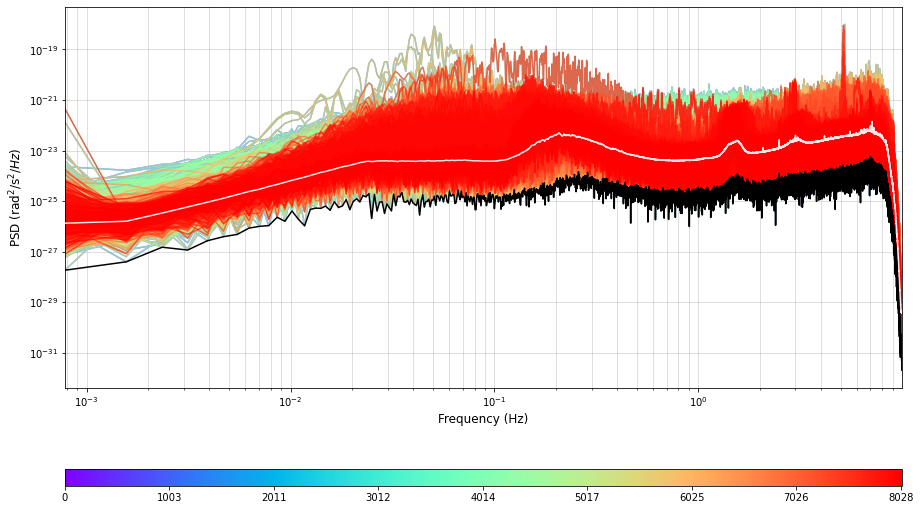

In [40]:
fig, out = __makeplot_colorlines(config, ff, psds, columns)

### Write to File

In [ ]:
# if config['save']:
#     out.to_csv(f"{inpath}{inname}.csv", sep=",")
#     print(f" -> writing to {inpath}{inname}.csv")

## Plot as DeciBel

In [ ]:
def __conversion(data, informat=None, outformat=None):
    '''
    data:                  array 
    informat/outformat:    ASD, PSD, DB
    '''
    from numpy import log10, sqrt
    
    
    if informat == 'ASD' and outformat == 'PSD':
        return data**2
    
    elif informat == 'PSD' and outformat == 'ASD':
        return sqrt(data)

    elif informat == 'ASD' and outformat == 'DB':
        return 10*log10(data)
    
    elif informat == 'PSD' and outformat == 'DB':
        return 10*log10(data)
    
    elif informat == 'DB' and outformat == 'PSD':
        return 10**(data/10)
    
    elif informat == 'DB' and outformat == 'ASD':
        return sqrt(10**(data/10))
    
    else:
        print(" -> specified case not defined!")

In [ ]:
psds_db = __conversion(psds, informat="PSD", outformat="DB")

In [ ]:
def __makeplot_colorlines_decibel(config, ff, psds, columns):

    from numpy import isnan, median, mean, std, array
    from scipy.stats import median_abs_deviation as mad
    
    psds_median, psds_mean, psds_std, psds_mad = [],[],[],[]
    for fcross in range(psds.shape[1]):
        data = psds[:,fcross]
        psds_median.append(median(data[~isnan(data)]))
        psds_mean.append(mean(data[~isnan(data)]))
        psds_std.append(std(data[~isnan(data)]))
        psds_mad.append(mad(data[~isnan(data)]))
    
    psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)
    
    
    ##____________________________
    
    fig, ax = plt.subplots(1,1, figsize=(15,10), sharey=False, sharex=True)

    font = 12

    N = psds.shape[0]
    colors = plt.cm.rainbow(linspace(0, 1, N))


    for n, psd in enumerate(psds):
        ax.semilogx(ff, psd, color=colors[n], alpha=0.7)

    ## add scatter for colorbar object only
    for n, psd in enumerate(psds):
        p2 = ax.scatter(ff[0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)

    ax.semilogx(ff, psds_median, 'black', zorder=3, alpha=0.9)
    ax.semilogx(ff, array(psds_median)+array(psds_mad), 'grey', zorder=3, alpha=0.8)  
    ax.semilogx(ff, array(psds_median)-array(psds_mad), 'grey', zorder=3, alpha=0.8)  

#     ax.semilogx(ff, psds_minimal, 'black', zorder=2, alpha=1.0)
    

    ax.set_xlabel("Frequency (Hz)", fontsize=font)

    ax.set_ylabel(r"PSD (dB rel. to 1 $rad^2$/($s^2$ $Hz$)", fontsize=font)
  
    ax.grid(True, which="both", ls="-", alpha=0.5)

    
    ax.set_xlim(min(ff), max(ff))
#     ax.set_xlim(10**log10(config['frequency_limits'][0]), 10**log10(config['frequency_limits'][1]))
    
    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='horizontal', ax=ax, aspect=50)

    ## redefine ticks of colorbar
    dates = columns
    new_ticks=[]
    for t in cbar.get_ticks(): 
        new_ticks.append(dates.astype(str)[int(t)])
    cbar.ax.set_xticklabels(new_ticks)


    plt.show();
    
    out = DataFrame()
    out['frequencies'] = ff
    out['psds_minimal'] = array(psds_minimal)
    out['psds_median'] = array(psds_median)
    out['psds_mean'] = array(psds_mean)
    out['psds_std'] = array(psds_std)
    out['psds_mad'] = array(psds_mad)
    
    return fig, out

In [ ]:
fig, out_db = __makeplot_colorlines_decibel(config, ff, psds_db, columns)

### Write to file

In [ ]:
if config['save']:
    out_db.to_csv(f"{inpath}{inname}_DB.csv", sep=",")
    print(f" -> writing to {inpath}{inname}_DB.csv")

## Calculate and Plot Density

Convert to logaritmic values

In [ ]:
# def __convert_to_log(psds):

#     print(psds.shape)

#     psds_new = zeros(psds.shape)
#     rows_with_zeros = 0
#     for i, psd in enumerate(psds):
#         if count_nonzero(psd) != len(psd):
#             rows_with_zeros +=1
#             psd = [nan for val in psd if val == 0]
#         psds_new[i,:] = log10(psd)
#         if isinf(psds_new[i,:]).any():
#             psds_new[i,:] = nan * ones(len(psds_new[i,:]))
            
#     return psds_new

# psds_log = __convert_to_log(psds)

In [ ]:
def __calculate_density(psd_array, bins=20, density=False):

    from numpy import argmax, std, median, isnan, array, histogram, nan, zeros, count_nonzero, log10, isinf
    from scipy.stats import median_abs_deviation as mad
    
    def __convert_to_log(in_psds):

        print(in_psds.shape)

        out_psds = zeros(in_psds.shape)
        rows_with_zeros = 0
        for i, psd in enumerate(in_psds):
            if count_nonzero(psd) != len(psd):
                rows_with_zeros +=1
                psd = [nan for val in psd if val == 0]
            out_psds[i,:] = log10(psd)
            if isinf(out_psds[i,:]).any():
                out_psds[i,:] = nan * ones(len(out_psds[i,:]))

        return out_psds

    psd_array = __convert_to_log(psd_array)
    
    ## exclude psds with only NaN values
    psds = array([psd for psd in psd_array if not isnan(psd).all()])

    ## find overall minimum and maxium values
    max_value = max([max(sublist) for sublist in psd_array])
    min_value = min([min(sublist) for sublist in psd_array])
    print(min_value, max_value)

    ## define empty lists
    dist, dist_maximas, bins_maximas, bins_medians, stds, mads = [], [], [], [], [], []
    
    count = 0

    for h in range(len(psd_array[1])):
        
        psd = psd_array[:,h]
        
        hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=density);
                
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        ## normalization
#         if  True:
#             hist = [val / len(psd_array[:,h]) for val in hist]
#             config['set_density'] = True

        ## check if density works
        DX = abs(max_value-min_value)/bins
        SUM = sum(hist)
        if str(SUM*DX) != "1.0":
            count+=1
        
        ## modify histogram with range increment
        hist = hist*DX
        
        ## append values to list
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        mads.append(mad(hist)) 
        
        ## compute median
        psd = psd[~(isnan(psd))]
        bins_medians.append(median(psd[psd != 0]))

    ## undo log conversion    
    output = {}
    output['dist'] = array(dist)
    output['bin_mids'] = 10**array(bin_mids)
    output['bins_maximas'] = 10**array(bins_maximas)
    output['stds'] = 10**array(stds)
    output['mads'] = 10**array(mads)
    output['bins_medians'] = 10**array(bins_medians)
    output['set_density'] = density
    output['total'] = psd_array.shape[0]
    
    if count > 0:
        print(f" {count} errors found for density computation!!!")
    
    return output

In [ ]:
# def __calculate_density(psd_array, bins=20, density=False):

#     from numpy import argmax, std, median, isnan, array, histogram

#     ## exclude psds with only NaN values
#     psds = array([psd for psd in psd_array if not isnan(psd).all()])

    
#     ## find overall minimum and maxium values
#     max_value = max([max(sublist) for sublist in psd_array])
#     min_value = min([min(sublist) for sublist in psd_array])
#     print(min_value, max_value)

#     ## define empty lists
#     dist, dist_maximas, bins_maximas, bins_medians, stds, mads = [], [], [], [], [], []
    
#     for h in range(len(psd_array[1])):
        
#         psd = psd_array[:,h]
        
#         hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=density);
        
#         bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
# #         if density:
# #             hist = [val / len(psd_array[:,h]) for val in hist]

#         ## check if density works
#         DX = abs(max_value-min_value)/bins
#         SUM = sum(hist)
#         if str(SUM*DX) != "1.0":
#             count+=1
        
#         ## modify histogram with range increment
#         hist = hist*DX
        
#         ## append values to list
#         dist.append(hist)
#         stds.append(std(hist))
#         dist_maximas.append(max(hist))
#         bins_maximas.append(bin_mids[argmax(hist)])
#         mads.append(mad(hist)) 
        
#         ## compute median
#         psd = psd[~(isnan(psd))]
#         bins_medians.append(median(psd[psd != 0]))

#     ## undo log conversion    
#     output = {}
#     output['dist'] = array(dist)
#     output['bin_mids'] = 10**array(bin_mids)
#     output['bins_maximas'] = 10**array(bins_maximas)
#     output['stds'] = 10**array(stds)
#     output['mads'] = 10**array(mads)
#     output['bins_medians'] = 10**array(bins_medians)
#     output['set_density'] = density
#     output['total'] = psd_array.shape[0]
    
#     if count > 0:
#         print(f" {count} errors found for density computation!!!")
    
    
#     return output

In [ ]:
output = __calculate_density(psds, bins=200, density=True)

In [ ]:
def __makeplot_PPSD(ff, output, config):

    from matplotlib import colors
    from numpy import ones, convolve

    
    def moving_average(x, w):
        return convolve(x, ones(w), 'same') / w

    
    bins, bins_medians, bins_maximas, dist = output['bin_mids'], output['bins_medians'], output['bins_maximas'], output['dist']
    
    y_axis = 10**bins
    x_axis = ff

    
    
    ## plotting
    fig = plt.figure(figsize=(13,6))

    font=14

    cmap = plt.cm.get_cmap('magma_r')
    cmap.set_under(color='white')

    im = plt.pcolor(x_axis, y_axis, dist.T, 
                    cmap=cmap,
                    vmin=1e-12, 
#                     norm=colors.LogNorm(), 
                   )

    fs = x_axis[2]-x_axis[1]
    
    bins_maximas_avg = moving_average(bins_maximas, 5)
    
    plt.plot(x_axis+fs/2, 10**array(bins_maximas_avg), color='black', alpha=0.5)
    plt.plot(x_axis+fs/2, 10**array(bins_medians), color='white', alpha=0.5)
    

    plt.xscale('log')
    plt.yscale('log')

#     plt.xlim(config['frequency_limits'][0], config['frequency_limits'][1])
#     plt.xlim(min(ff), max(ff))
    plt.xlim(0.005, 5)

    ## ROMY
#     plt.ylim(10**-24, 10**-16)

    ##RLAS
    plt.ylim(10**-27, 10**-17)
    
    caxes = fig.add_axes()

    cb = plt.colorbar(im, cax=caxes)
    
    if output['set_density']:
        cb.set_label("Propability Density", fontsize=font)
    else:
        cb.set_label("Counts", fontsize=font)
    
    plt.ylabel(r"PPSD (rad$^2$/s$^2$/$Hz)$", fontsize=font)
    # plt.ylabel(f"PSD (dB rel. to {round(max_value,3)} V$^2$/Hz )",fontsize=font)
    plt.xlabel("Frequency (Hz)",fontsize=font)
    plt.title(f"PPSD {config['ring']} [{config['date1'].date} - {config['date2'].date}]; total = {output['total']}",fontsize=font+2)
    
    plt.tick_params(axis='both', labelsize=font-2)

    plt.show();
    return fig

In [ ]:
fig = __makeplot_PPSD(ff, output, config)

In [ ]:
output = __calculate_density(psds, bins=100, density=True)

In [ ]:
def __makeplot_PPSD(ff, output, config, mode=None):

    from matplotlib import colors
    from numpy import ones, convolve, array, log10, roll, sqrt

    bins, bins_medians, bins_maximas, dist = output['bin_mids'], output['bins_medians'], output['bins_maximas'], output['dist']
    
    if mode is "DB":
        y_axis = 10*log10(bins)
    elif mode is "PSD":
        y_axis = bins
    elif mode is "ASD":
        y_axis = sqrt(bins)
        
    x_axis = ff

    ## plotting
    fig, ax = plt.subplots(1,1,figsize=(13,6))

    font=14

    cmap = plt.cm.get_cmap('magma_r')
#     cmap = plt.cm.get_cmap('gray_r')
    cmap.set_under(color='white')

    im = plt.pcolor(x_axis, y_axis, dist.T, 
                    cmap=cmap,
                    vmin=1e-12, 
                    alpha=0.99,
                   )

    ## add Frequency Axis
    g = lambda x: 1/x
    ax2 = ax.secondary_xaxis("top", functions=(g,g))
    ax2.set_xlabel("Frequency in Hz", fontsize=font, labelpad=5)
    ax2.set_xticklabels(1/ff, fontsize=11)    
    
    
    if mode is "DB":
        plt.plot(x_axis, 10*log10(bins_medians), color='black', alpha=0.5, label="RNLM")
        plt.ylim(-200, -80)

    elif mode is "PSD":
        plt.plot(x_axis, bins_medians, color='black', alpha=0.5, label="RNLM")
        plt.yscale('log')
        plt.ylim(10**-20, 10**-13)
  
    elif mode is "ASD":  
        plt.plot(x_axis, sqrt(bins_medians), color='black', alpha=0.5, label="RNLM")
        plt.yscale('log')
        plt.ylim(10**-10, 2*10**-7)

    
#     plt.fill_betweenx(range(-270, -140), x1=0, x2=2.5, color="grey", alpha=0.4)
#     plt.fill_betweenx(range(-270, -140), x1=200, x2=max(ff), color="grey", alpha=0.4)

    ## modify x-axis
    plt.xscale('log')
    plt.xlim([min(x_axis), max(x_axis)])
#     plt.xlim(1, 300)
    
    ## add colorbar
    caxes = fig.add_axes()
    cb = plt.colorbar(im, cax=caxes, alpha=1.0)
    
    if output['set_density']:
        cb.set_label("Propability Density", fontsize=font)
    else:
        cb.set_label("Counts", fontsize=font)
        cb.set_label("Propability Density", fontsize=font)
    
    if mode is "DB":
#         plt.ylabel(r"PPSD in dB (rel. to 1 m$^4$/s$^2$/$Hz$)", fontsize=font)
        plt.ylabel(r"PPSD in dB (rel. to 1 rad$^2$/s$^2$/$Hz$)", fontsize=font)
    elif mode is "PSD":
#         plt.ylabel(r"PPSD in m$^4$/s$^2$/$Hz$", fontsize=font)
        plt.ylabel(r"PPSD in $\frac{rad^2}{s^2 Hz}$", fontsize=font)
    elif mode is "ASD":
        plt.ylabel(r"PASD in $\frac{rad}{s \sqrt{Hz}}$", fontsize=font)
        
    plt.grid(axis="both", which="both", ls="--", zorder=0)
    plt.legend()
    
    plt.xlabel("Period in seconds", fontsize=font)

    plt.tick_params(axis='both', labelsize=font-2)

    plt.show();
    return fig

In [ ]:
fig = __makeplot_PPSD(ff, output, config, mode="ASD")